# Modern Data Lakehouse with NYC Taxi Dataset

## 🎯 Project Objective

In this tutorial you will build a **modern data lakehouse** using open-source technologies to process real NYC taxi data. You will implement a **three-zone architecture** (Landing → Staging → Curated) that will allow you to:

- Manage **millions of records** of NYC taxi trips
- Maintain **immutability of raw data** (Landing Zone)
- Apply **data quality and transformations** (Staging Zone)  
- Produce **aggregations optimized for BI** (Curated Zone)
- Support **time travel** and **schema evolution** thanks to Iceberg

---

## 🏛️ Architecture Stack

### Key Components

```
┌─────────────────────────────────────────────────────┐
│  Trino (Query Engine)                               │
│  - Executes SQL on Iceberg                          │
│  - Coordinates reads/writes                         │
└─────────────────┬───────────────────────────────────┘
                  │
┌─────────────────▼───────────────────────────────────┐
│  Apache Polaris (Catalog)                           │
│  - Manages Iceberg metadata                         │
│  - OAuth2 authentication                            │
│  - Namespace management                             │
└─────────────────┬───────────────────────────────────┘
                  │
┌─────────────────▼───────────────────────────────────┐
│  MinIO (Object Storage)                             │
│  - S3-compatible storage                            │
│  - Bucket: warehouse/ (Iceberg tables)              │
└─────────────────────────────────────────────────────┘
```

### Why This Architecture?

- **Polaris**: Enterprise-grade catalog with security and multi-tenancy
- **Trino**: Distributed SQL engine with excellent performance
- **Iceberg**: Table format with ACID, time travel, schema evolution
- **MinIO**: S3-compatible local storage for development/testing

---

## 📋 Prerequisites

Before starting, make sure you have:

1. ✅ **Started Docker containers** with `docker compose up -d`
2. ✅ **Verified all services are active** with `docker ps`
3. ✅ **Checked Trino properties** in `trino/catalog/iceberg.properties`

### Verify Active Services

The following services must be reachable:

- 🔵 **Polaris**: http://localhost:8181
- 🟢 **Trino**: http://localhost:8080  
- 🟠 **MinIO**: http://localhost:9000

---

## ⚠️ Note on Data

The complete dataset `yellow_tripdata_2025-02.parquet` contains **millions of records** and takes a long time to load. 

In this tutorial:
- I'll show you how to **create a reduced sample** of the dataset (~5000 rows)
- You can decide whether to use the sample or complete dataset
- The sample is **ideal for testing and learning**

---
## 📊 Data Architecture: The Three Zones

Before proceeding with implementation, it's important to understand the **zone philosophy** in our lakehouse.

### Data Flow

```
Parquet Dataset → [Landing] → [Staging] → [Curated] → BI Dashboard
                   immutable   validated   aggregated
```

### Zone Description

| Zone | Purpose | Format | Immutability | Who Accesses |
|------|---------|--------|--------------|--------------|
| **Landing** | Exact source replica | Original schema | ✅ Read-only | Ingest pipeline |
| **Staging** | Cleaned and typed data | Optimized schema | ❌ Continuous transformations | Data engineers |
| **Curated** | Business aggregations | Denormalized | ❌ Periodic refreshes | Analysts, BI tools |

### Physical Storage Layout on MinIO

```
s3://warehouse/
├── landing/
│   └── raw_taxi_trips/          ← Raw data from Parquet
│       ├── metadata/
│       │   ├── v1.metadata.json
│       │   └── snap-xxx.avro
│       └── data/
│           └── 00000-0-xxx.parquet
├── staging/
│   └── clean_taxi_trips/        ← Cleaned and validated data
│       ├── metadata/
│       └── data/
│           ├── year=2025/
│           │   └── month=02/
│           │       └── day=01/
│           │           └── xxx.parquet
└── curated/
    └── hourly_trip_stats/       ← Aggregations for analysis
        ├── metadata/
        └── data/
```

**Note:** Each zone has a specific purpose. The **Landing** preserves original data (never modify it!), **Staging** cleans it, and **Curated** prepares it for analysis.

---
## 🔐 Part 1: Apache Polaris Setup

Polaris is the **central catalog** that tracks all Iceberg table metadata. Before creating any table, we need to configure it.

### What we'll do in this part:

1. ✅ Get an **OAuth2 token** to authenticate
2. ✅ Create the **catalog** `polariscatalog`
3. ✅ Create the **namespaces** (landing, staging, curated)

---

### Step 1.1: Get an OAuth2 Access Token

**What happens here?**
- Polaris uses OAuth2 for authentication (like when you login with Google)
- Every operation requires a valid token
- The token has an expiration (typically 1 hour)

**Credentials used:**
- `client_id`: root
- `client_secret`: secret  
- Defined in `docker-compose.yml` → `POLARIS_BOOTSTRAP_CREDENTIALS`

In [1]:
import requests
import json

# Endpoint to get OAuth2 token
token_url = "http://localhost:8181/api/catalog/v1/oauth/tokens"

# Credentials (defined in docker-compose.yml)
token_data = {
    "grant_type": "client_credentials",
    "client_id": "root",
    "client_secret": "secret",
    "scope": "PRINCIPAL_ROLE:ALL"
}

# Token request
response = requests.post(token_url, data=token_data)
token_response = response.json()
ACCESS_TOKEN = token_response["access_token"]

print(f"✅ Token obtained successfully!")
print(f"Token (first 50 characters): {ACCESS_TOKEN[:50]}...")

✅ Token obtained successfully!
Token (first 50 characters): eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJwb...


### Step 1.2: Create the Iceberg Catalog

Now we create the `polariscatalog` catalog in Polaris. A catalog is a logical container for your schemas and tables.

**What we specify:**
- `default-base-location`: where Iceberg tables will be saved (S3 bucket in MinIO)
- S3 credentials to access MinIO
- `storageConfigInfo`: security configuration to limit where data can be written

In [2]:
# URL to create the catalog
catalog_url = "http://localhost:8181/api/management/v1/catalogs"

# Headers with authentication token
headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}",
    "Content-Type": "application/json"
}

# Catalog configuration
catalog_config = {
    "name": "polariscatalog",
    "type": "INTERNAL",
    "properties": {
        "default-base-location": "s3://warehouse",
        "s3.endpoint": "http://minio:9000",
        "s3.path-style-access": "true",
        "s3.access-key-id": "admin",
        "s3.secret-access-key": "password",
        "s3.region": "dummy-region"
    },
    "storageConfigInfo": {
        "roleArn": "arn:aws:iam::000000000000:role/minio-polaris-role",
        "storageType": "S3",
        "allowedLocations": [
            "s3://warehouse/*"
        ]
    }
}

# Create catalog
response = requests.post(catalog_url, headers=headers, json=catalog_config)

if response.status_code in [200, 201]:
    print("✅ Catalog 'polariscatalog' created successfully!")
else:
    print(f"❌ Error creating catalog: {response.status_code}")
    print(response.text)

✅ Catalog 'polariscatalog' created successfully!


### Step 1.3: Verify Catalog Creation

Let's verify that the catalog was created correctly by querying Polaris API.

In [3]:
# Retrieve list of catalogs
response = requests.get(catalog_url, headers=headers)
catalogs = response.json()

print("📋 Available catalogs:")
print(json.dumps(catalogs, indent=2))

📋 Available catalogs:
{
  "catalogs": [
    {
      "type": "INTERNAL",
      "name": "polariscatalog",
      "properties": {
        "s3.path-style-access": "true",
        "s3.access-key-id": "admin",
        "s3.secret-access-key": "password",
        "default-base-location": "s3://warehouse",
        "s3.region": "dummy-region",
        "s3.endpoint": "http://minio:9000"
      },
      "createTimestamp": 1762175828005,
      "lastUpdateTimestamp": 1762175828005,
      "entityVersion": 1,
      "storageConfigInfo": {
        "roleArn": "arn:aws:iam::000000000000:role/minio-polaris-role",
        "pathStyleAccess": false,
        "storageType": "S3",
        "allowedLocations": [
          "s3://warehouse/*",
          "s3://warehouse"
        ]
      }
    }
  ]
}


---

### Step 1.4: Create Namespaces (Zones)

**What are namespaces?**
- They are like "logical folders" for organizing tables
- Each lakehouse zone will be a separate namespace
- They correspond to subfolders in `s3://warehouse/`

**Our namespaces:**
- 🔵 `landing` → raw data, immutable
- 🟢 `staging` → cleaned, validated data
- 🟠 `curated` → business aggregations

In [4]:
# URL to manage namespaces
namespaces_url = "http://localhost:8181/api/catalog/v1/polariscatalog/namespaces"

# Configuration for three namespaces
namespaces = [
    {
        "namespace": ["landing"],
        "properties": {
            "description": "Landing Zone - Raw immutable source data"
        }
    },
    {
        "namespace": ["staging"],
        "properties": {
            "description": "Staging Zone - Cleaned and validated data"
        }
    },
    {
        "namespace": ["curated"],
        "properties": {
            "description": "Curated Zone - Business-ready aggregated data"
        }
    }
]

# Create each namespace
print("🏗️  Creating namespaces...")
for ns_config in namespaces:
    ns_name = ns_config["namespace"][0]
    
    response = requests.post(namespaces_url, headers=headers, json=ns_config)
    
    if response.status_code in [200, 201]:
        print(f"   ✅ Namespace '{ns_name}' created!")
    elif response.status_code == 409:
        print(f"   ℹ️  Namespace '{ns_name}' already exists (OK)")
    else:
        print(f"   ❌ Error for '{ns_name}': {response.status_code}")
        print(f"      {response.text}")

print("\n✅ Polaris setup completed!")
print("\n📋 Summary:")
print("   🔵 Catalog: polariscatalog")
print("   🗂️  Namespaces: landing, staging, curated")
print("   📂 Storage: s3://warehouse/")

🏗️  Creating namespaces...
   ✅ Namespace 'landing' created!
   ✅ Namespace 'staging' created!
   ✅ Namespace 'curated' created!

✅ Polaris setup completed!

📋 Summary:
   🔵 Catalog: polariscatalog
   🗂️  Namespaces: landing, staging, curated
   📂 Storage: s3://warehouse/


### Step 1.5: Verify Created Namespaces

Let's check that namespaces were created correctly.

In [5]:
# Retrieve namespace list
response = requests.get(namespaces_url, headers=headers)

if response.status_code == 200:
    namespaces_data = response.json()
    print("📋 Available namespaces in polariscatalog:")
    print(json.dumps(namespaces_data, indent=2))
else:
    print(f"❌ Error retrieving namespaces: {response.status_code}")
    print(response.text)

📋 Available namespaces in polariscatalog:
{
  "namespaces": [
    [
      "landing"
    ],
    [
      "staging"
    ],
    [
      "curated"
    ]
  ],
  "next-page-token": null
}


---
## 📥 Part 2: NYC Taxi Dataset Preparation

### 🔄 ELT - Phase E (Extract)

In the **ELT** (Extract, Load, Transform) model, this is the **E (Extract)** phase:
- **Extract** → Read source dataset (Parquet)
- Load → Load to Landing Zone (Part 3)
- Transform → Transformations in Staging Zone (Part 4)

Before loading the data, we need to decide which dataset to use.

---

### ⚠️ Important Choice: Complete Dataset vs Sample

**Complete Dataset** (`yellow_tripdata_2025-02.parquet`):
- ✅ Complete real data (~3.5M rows)
- ❌ Load time: 10-30 minutes
- ❌ Requires more resources

**Reduced Sample** (`yellow_tripdata_sample.parquet`):
- ✅ Fast for testing (5000 rows)
- ✅ Load time: 1-2 minutes
- ✅ Ideal for learning
- ❌ Not representative for real analysis

### Step 2.1: Verify Dataset Existence

Let's check if you already have the original Parquet file.

In [6]:
import os
import pandas as pd

# File paths
ORIGINAL_FILE = "/home/llussu/lakehouse-lab/data/yellow_tripdata_2025-02.parquet"
SAMPLE_FILE = "/home/llussu/lakehouse-lab/data/yellow_tripdata_sample.parquet"

# Verify existence
if os.path.exists(ORIGINAL_FILE):
    size_mb = os.path.getsize(ORIGINAL_FILE) / (1024 * 1024)
    print(f"✅ Original dataset found: {ORIGINAL_FILE}")
    print(f"   📦 Size: {size_mb:.1f} MB")
    
    # Read metadata without loading everything in memory
    df_peek = pd.read_parquet(ORIGINAL_FILE)
    print(f"   📊 Total rows: {len(df_peek):,}")
    print(f"   📋 Columns: {len(df_peek.columns)}")
    print(f"\n   Available columns:")
    for col in df_peek.columns:
        print(f"      - {col}")
else:
    print(f"❌ File not found: {ORIGINAL_FILE}")
    print("   💡 Make sure you've downloaded the NYC Taxi dataset")

# Verify sample
if os.path.exists(SAMPLE_FILE):
    print(f"\n✅ Sample already exists: {SAMPLE_FILE}")
else:
    print(f"\nℹ️  Sample not found. We'll create it in the next step.")

✅ Original dataset found: /home/llussu/lakehouse-lab/data/yellow_tripdata_2025-02.parquet
   📦 Size: 57.5 MB
   📊 Total rows: 3,577,543
   📋 Columns: 20

   Available columns:
      - VendorID
      - tpep_pickup_datetime
      - tpep_dropoff_datetime
      - passenger_count
      - trip_distance
      - RatecodeID
      - store_and_fwd_flag
      - PULocationID
      - DOLocationID
      - payment_type
      - fare_amount
      - extra
      - mta_tax
      - tip_amount
      - tolls_amount
      - improvement_surcharge
      - total_amount
      - congestion_surcharge
      - Airport_fee
      - cbd_congestion_fee

✅ Sample already exists: /home/llussu/lakehouse-lab/data/yellow_tripdata_sample.parquet


### Step 2.2: Create Sample (OPTIONAL)

**Run this cell ONLY if you want to use sample to speed up tutorial.**

This code:
1. Reads complete Parquet file
2. Extracts 5000 random rows
3. Saves sample to new file

⏱️ **Estimated time:** 30-60 seconds

In [7]:
# 🚨 RUN THIS CELL ONLY IF YOU WANT TO CREATE THE SAMPLE

if not os.path.exists(SAMPLE_FILE):
    print("🔨 Creating sample...")
    print(f"   Reading from: {ORIGINAL_FILE}")
    
    # Read complete dataset
    df = pd.read_parquet(ORIGINAL_FILE)
    print(f"   ✓ Read: {len(df):,} rows")
    
    # Create random sample
    SAMPLE_SIZE = 5000
    df_sample = df.sample(n=SAMPLE_SIZE, random_state=42)
    print(f"   ✓ Sample extracted: {len(df_sample):,} rows")
    
    # Save sample
    os.makedirs(os.path.dirname(SAMPLE_FILE), exist_ok=True)
    df_sample.to_parquet(SAMPLE_FILE, index=False)
    
    sample_size_mb = os.path.getsize(SAMPLE_FILE) / (1024 * 1024)
    print(f"\n✅ Sample created successfully!")
    print(f"   📂 File: {SAMPLE_FILE}")
    print(f"   📊 Rows: {len(df_sample):,}")
    print(f"   📦 Size: {sample_size_mb:.2f} MB")
    print(f"   📉 Ratio: {(len(df_sample)/len(df)*100):.2f}% of original data")
    
    # Show preview
    print(f"\n👀 Preview of first 3 records:")
    print(df_sample.head(3).to_string())
else:
    print("ℹ️  Sample already exists. If you want to recreate it, delete the file first.")
    print(f"   File: {SAMPLE_FILE}")

ℹ️  Sample already exists. If you want to recreate it, delete the file first.
   File: /home/llussu/lakehouse-lab/data/yellow_tripdata_sample.parquet


---
## 🎬 Part 3: Landing Zone - Ingest Raw Data

### 🔄 ELT - Phase L (Load)

In the **ELT** (Extract, Load, Transform) model, this is the **L (Load)** phase:
- Extract → Read Parquet ✅ Done in Part 2
- **Load** → Load to immutable Landing Zone
- Transform → Transformations (Part 4)

**Objective of this phase:**
- Load the Parquet into an Iceberg table in the **Landing Zone**
- Preserve exact schema of original file
- Make data **immutable** (read-only for next phases)

**What we'll do:**
1. Connect to Trino (query engine)
2. Create `raw_taxi_trips` table in `landing` namespace
3. Load data from Parquet

### Why Trino?

Trino is the "SQL engine" that:
- Speaks with Polaris for metadata
- Writes to MinIO (S3 storage)
- Manages Iceberg transactions

---

### Step 3.1: Choose Dataset to Use

**Choose which Parquet file to load.**

In [9]:
### Step 3.1: Choose Dataset to Use

# Choose which Parquet file to load.

# Set which file to use (choose one):
# PARQUET_FILE = ORIGINAL_FILE  # Use complete dataset (slow)
PARQUET_FILE = SAMPLE_FILE      # Use sample (fast - recommended for tutorial)

### Step 3.2: Connect to Trino

Now let's connect to Trino using SQLAlchemy. This allows us to execute SQL directly from Python.

**Connection parameters:**
- Host: `localhost` (Trino is exposed on port 8080)
- User: `admin` (no password required in dev mode)
- Catalog: `iceberg` (defined in `trino/catalog/iceberg.properties`)
- Schema: `landing` (namespace we created)

In [10]:
from sqlalchemy import create_engine, text

# Trino connection configuration
TRINO_HOST = "localhost"
TRINO_PORT = 8080
TRINO_USER = "admin"
TRINO_CATALOG = "iceberg"
TRINO_SCHEMA = "landing"

print("🔌 Connecting to Trino...")
engine = create_engine(
    f'trino://{TRINO_USER}@{TRINO_HOST}:{TRINO_PORT}/{TRINO_CATALOG}/{TRINO_SCHEMA}'
)

# Test connection
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT 1 as test"))
        test_value = result.fetchone()[0]
        if test_value == 1:
            print("✅ Connection to Trino successful!")
            print(f"   📍 Endpoint: {TRINO_HOST}:{TRINO_PORT}")
            print(f"   📂 Catalog: {TRINO_CATALOG}")
            print(f"   🗂️  Schema: {TRINO_SCHEMA}")
except Exception as e:
    print(f"❌ Connection error: {e}")
    print("\n💡 Verify that Trino is active:")
    print("   docker ps | grep trino")

🔌 Connecting to Trino...
✅ Connection to Trino successful!
   📍 Endpoint: localhost:8080
   📂 Catalog: iceberg
   🗂️  Schema: landing


### Step 3.3: Data Preparation

Before loading, we read the Parquet and normalize column names.

**⚠️ Important Note:** You're normalizing data **in memory** (Python DataFrame), NOT modifying the original Parquet file!

**Why normalize?**
- Column names in Parquet may have mixed case
- SQL is case-insensitive but conventionally uses lowercase
- Iceberg prefers standardized column names
- Source file remains **intact** on disk

In [11]:
print("📖 Reading Parquet...")
df = pd.read_parquet(PARQUET_FILE)

print(f"   ✓ Rows read: {len(df):,}")
print(f"   ✓ Original columns: {len(df.columns)}")

# Show original columns
print("\n   Columns before normalization:")
for col in df.columns[:5]:  # First 5
    print(f"      - {col}")
if len(df.columns) > 5:
    print(f"      ... and {len(df.columns) - 5} more")

# 🔧 Normalize column names: all lowercase
df.columns = [col.lower() for col in df.columns]

print(f"\n   ✓ Columns normalized (lowercase)")
print("\n   Columns after normalization:")
for col in df.columns:
    print(f"      - {col}")

# Show data type info
print(f"\n📋 DataFrame schema:")
print(df.dtypes)

# Data preview
print(f"\n👀 First 3 records:")
print(df.head(3))

📖 Reading Parquet...
   ✓ Rows read: 5,000
   ✓ Original columns: 20

   Columns before normalization:
      - VendorID
      - tpep_pickup_datetime
      - tpep_dropoff_datetime
      - passenger_count
      - trip_distance
      ... and 15 more

   ✓ Columns normalized (lowercase)

   Columns after normalization:
      - vendorid
      - tpep_pickup_datetime
      - tpep_dropoff_datetime
      - passenger_count
      - trip_distance
      - ratecodeid
      - store_and_fwd_flag
      - pulocationid
      - dolocationid
      - payment_type
      - fare_amount
      - extra
      - mta_tax
      - tip_amount
      - tolls_amount
      - improvement_surcharge
      - total_amount
      - congestion_surcharge
      - airport_fee
      - cbd_congestion_fee

📋 DataFrame schema:
vendorid                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
ratecodeid    

### Step 3.4: Creating the Iceberg Table

Now we create the `raw_taxi_trips` table in the Landing Zone.

**What happens here:**
1. We delete the table if it already exists (to be able to start from scratch)
2. We create a new Iceberg table with the correct schema
3. We specify `format = 'PARQUET'` for storage
4. We define `location` on MinIO (s3://warehouse/landing/...)

**Important note:** The table is empty after creation. We load the data in the next step.

In [12]:
with engine.connect() as conn:
    print("🏗️  Creating Iceberg table...")
    
    # Drop if exists (to start fresh)
    try:
        conn.execute(text("DROP TABLE IF EXISTS raw_taxi_trips"))
        conn.commit()
        print("   ✓ Existing table removed")
    except Exception as e:
        print(f"   ℹ️  No existing table to remove")
    
    # Create table with exact schema of NYC Taxi Parquet
    create_sql = """
    CREATE TABLE raw_taxi_trips (
        vendorid INTEGER,
        tpep_pickup_datetime TIMESTAMP(6),
        tpep_dropoff_datetime TIMESTAMP(6),
        passenger_count BIGINT,
        trip_distance DOUBLE,
        ratecodeid BIGINT,
        store_and_fwd_flag VARCHAR,
        pulocationid INTEGER,
        dolocationid INTEGER,
        payment_type BIGINT,
        fare_amount DOUBLE,
        extra DOUBLE,
        mta_tax DOUBLE,
        tip_amount DOUBLE,
        tolls_amount DOUBLE,
        improvement_surcharge DOUBLE,
        total_amount DOUBLE,
        congestion_surcharge DOUBLE,
        airport_fee DOUBLE,
        cbd_congestion_fee DOUBLE
    )
    WITH (
        format = 'PARQUET',
        location = 's3://warehouse/landing/raw_taxi_trips/'
    )
    """
    
    conn.execute(text(create_sql))
    conn.commit()
    print("   ✅ Table 'raw_taxi_trips' created!")
    print(f"   📂 Location: s3://warehouse/landing/raw_taxi_trips/")
    print(f"   📋 Schema: 20 columns")
    print(f"   💾 Format: Parquet (optimized for reads)")

🏗️  Creating Iceberg table...
   ✓ Existing table removed
   ✓ Existing table removed
   ✅ Table 'raw_taxi_trips' created!
   📂 Location: s3://warehouse/landing/raw_taxi_trips/
   📋 Schema: 20 columns
   💾 Format: Parquet (optimized for reads)
   ✅ Table 'raw_taxi_trips' created!
   📂 Location: s3://warehouse/landing/raw_taxi_trips/
   📋 Schema: 20 columns
   💾 Format: Parquet (optimized for reads)


### Step 3.5: Load Data into Table

Now we load data from DataFrame into Iceberg table.

**Load strategy:**
- Load in **batches** (chunks) of 50,000 rows to avoid memory issues
- Each chunk written as separate transaction
- Iceberg automatically manages ACID transactions

In [13]:
import time

print("📥 Loading data (in batches)...")
print(f"   📊 Total rows to load: {len(df):,}")

# Batch configuration
chunk_size = 50000
total_chunks = (len(df) // chunk_size) + 1

print(f"   📦 Chunk size: {chunk_size:,} rows")
print(f"   🔢 Number of chunks: {total_chunks}")
print()

start_time = time.time()

# Load in chunks
for i in range(0, len(df), chunk_size):
    chunk = df.iloc[i:i+chunk_size]
    chunk_num = (i // chunk_size) + 1
    
    chunk_start = time.time()
    
    # Load chunk into table
    chunk.to_sql(
        'raw_taxi_trips',
        con=engine,
        if_exists='append',  # Add to existing data
        index=False,
        method='multi',
        chunksize=1000
    )
    
    chunk_time = time.time() - chunk_start
    
    print(f"   ✅ Chunk {chunk_num}/{total_chunks} loaded ({len(chunk):,} rows) - {chunk_time:.1f}s")

elapsed_time = time.time() - start_time

print(f"\n✅ Loading completed!")
print(f"   ⏱️  Total time: {elapsed_time:.1f} seconds")
print(f"   📊 Total rows: {len(df):,}")
print(f"   📈 Average speed: {len(df)/elapsed_time:.0f} rows/second")

📥 Loading data (in batches)...
   📊 Total rows to load: 5,000
   📦 Chunk size: 50,000 rows
   🔢 Number of chunks: 1

   ✅ Chunk 1/1 loaded (5,000 rows) - 13.8s

✅ Loading completed!
   ⏱️  Total time: 13.8 seconds
   📊 Total rows: 5,000
   📈 Average speed: 363 rows/second
   ✅ Chunk 1/1 loaded (5,000 rows) - 13.8s

✅ Loading completed!
   ⏱️  Total time: 13.8 seconds
   📊 Total rows: 5,000
   📈 Average speed: 363 rows/second


### Step 3.6: Verify Landing Zone

Let's verify data was loaded correctly into Landing Zone.

**Verification queries:**
1. Count total rows
2. Sample some rows
3. Basic statistics (dates, distances, fares)

In [14]:
print("🔍 Query on Iceberg table via Trino\n")

# Simple query: fetch 5 rows
query = """
SELECT * 
FROM raw_taxi_trips 
LIMIT 5
"""

print(f"SQL Query:\n{query}\n")
print("="*80)

# Execute query via SQLAlchemy
df_result = pd.read_sql(query, engine)

# Show result
print(df_result.to_string(index=False))

🔍 Query on Iceberg table via Trino

SQL Query:

SELECT * 
FROM raw_taxi_trips 
LIMIT 5


 vendorid tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  ratecodeid store_and_fwd_flag  pulocationid  dolocationid  payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  airport_fee  cbd_congestion_fee
        2  2025-02-14 09:37:47   2025-02-14 09:50:01                1           1.99           1                  N           238           163             1         12.8    0.0      0.5        3.51           0.0                    1.0         21.06                   2.5         0.00                0.75
        2  2025-02-07 21:40:08   2025-02-07 22:01:10                1           5.08           1                  N           100            74             1         24.7    1.0      0.5        6.09           0.0                    1.0         36.54                   2.5         0.00                0

---
## 🧹 Part 4: Staging Zone - Data Cleaning & Transformation

### 🔄 ELT - Phase T (Transform)

In the **ELT** (Extract, Load, Transform) model, this is the **T (Transform)** phase:
- Extract → Read Parquet ✅ Done in Part 2
- Load → Load to Landing Zone ✅ Done in Part 3
- **Transform** → **← PART 4: STAGING ZONE **

**The Staging Zone is the "T" (Transform) phase where:**
- ✅ Clean data (data quality)
- ✅ Apply transformations (derived columns)
- ✅ Optimize for queries (partitioning)

---

**Objective of this phase:**
- Create a **clean and validated** version of data
- Apply **data quality filters** (remove invalid records)
- Add **derived columns** useful for analysis
- Implement **date partitioning** (query optimization)

### What we'll do:

1. ✅ Analyze raw data quality
2. ✅ Define validation rules
3. ✅ Create partitioned `clean_taxi_trips` table
4. ✅ Transform and load clean data

---

### Staging Zone Philosophy

**Landing Zone vs Staging Zone:**

| Aspect | Landing | Staging |
|--------|---------|---------|
| **Data** | Raw, "as-is" | Cleaned, validated |
| **Schema** | Identical to source | Optimized |
| **Partitioning** | None | By date |
| **Columns** | Original only | + Derived columns |
| **Modification** | Never | Yes (transformations) |

---

### Step 4.1: Data Quality Analysis (EDA)

Before cleaning, let's understand what problems exist in raw data.

In [15]:
# Data Quality Analysis on Landing data

quality_check_query = """
SELECT
    COUNT(*) as total_records,
    COUNT(CASE WHEN trip_distance <= 0 THEN 1 END) as invalid_distance,
    COUNT(CASE WHEN total_amount <= 0 THEN 1 END) as invalid_amount,
    COUNT(CASE WHEN passenger_count <= 0 OR passenger_count IS NULL THEN 1 END) as invalid_passengers,
    COUNT(CASE WHEN tpep_pickup_datetime > tpep_dropoff_datetime THEN 1 END) as invalid_dates,
    COUNT(CASE 
        WHEN trip_distance > 0 
        AND total_amount > 0 
        AND passenger_count > 0
        AND tpep_pickup_datetime < tpep_dropoff_datetime
        AND tpep_pickup_datetime IS NOT NULL
        AND tpep_dropoff_datetime IS NOT NULL
        THEN 1 
    END) as valid_records
FROM raw_taxi_trips
"""

df_quality = pd.read_sql(quality_check_query, engine)

# Show results in table format
print("Data Quality Check:\n")
print(df_quality.to_string(index=False))

Data Quality Check:

 total_records  invalid_distance  invalid_amount  invalid_passengers  invalid_dates  valid_records
          5000               138              92                1149              0           3707


### Step 4.2: Define Transformation Rules

Now we define the **transformations** we'll apply to data to create Staging Zone.

**Transformations we'll make:**

1. **Quality filters** (remove invalid records):
   - `trip_distance > 0` → Exclude trips with no movement
   - `total_amount > 0` → Exclude null/negative fares
   - `passenger_count > 0` → Exclude trips with no passengers
   - `pickup < dropoff` → Exclude inconsistent dates

2. **Derived columns** (add useful information):
   - `trip_duration_minutes` → Duration in minutes (dropoff - pickup)
   - `avg_speed_mph` → Average speed (distance / duration)
   - `is_weekend` → Boolean: true if Saturday/Sunday
   - `hour_of_day` → Hour of day (0-23)
   - `date` → Date without time (for partitioning)

3. **Partitioning**:
   - Partition by `year`, `month`, `day` → Speeds up queries for period

---

**Why these transformations?**
- **Data Quality**: Ensures reliable data for analysis
- **Derived Columns**: Avoids repeated calculations in queries
- **Partitioning**: Queries on specific periods read only necessary files (performance!)

### Step 4.3: Create Partitioned Staging Table

We create the `clean_taxi_trips` table in **Staging Zone** with optimized schema.

**Differences from Landing:**
- ✅ Derived columns added
- ✅ Partitioned by date (year, month, day)
- ✅ Only records passing data quality

In [16]:
# Switch schema to 'staging'
staging_engine = create_engine(
    f'trino://{TRINO_USER}@{TRINO_HOST}:{TRINO_PORT}/{TRINO_CATALOG}/staging'
)

with staging_engine.connect() as conn:
    print("🏗️  Creating partitioned Staging table...\n")
    
    # Drop if exists
    try:
        conn.execute(text("DROP TABLE IF EXISTS clean_taxi_trips"))
        conn.commit()
        print("   ✓ Existing table removed")
    except Exception as e:
        print(f"   ℹ️  No existing table to remove")
    
    # Create table with derived columns and partitioning
    create_staging_sql = """
    CREATE TABLE clean_taxi_trips (
        -- Original columns
        vendorid INTEGER,
        tpep_pickup_datetime TIMESTAMP(6),
        tpep_dropoff_datetime TIMESTAMP(6),
        passenger_count BIGINT,
        trip_distance DOUBLE,
        ratecodeid BIGINT,
        store_and_fwd_flag VARCHAR,
        pulocationid INTEGER,
        dolocationid INTEGER,
        payment_type BIGINT,
        fare_amount DOUBLE,
        extra DOUBLE,
        mta_tax DOUBLE,
        tip_amount DOUBLE,
        tolls_amount DOUBLE,
        improvement_surcharge DOUBLE,
        total_amount DOUBLE,
        congestion_surcharge DOUBLE,
        airport_fee DOUBLE,
        cbd_congestion_fee DOUBLE,
        
        -- Derived columns (calculated)
        trip_duration_minutes DOUBLE,
        avg_speed_mph DOUBLE,
        is_weekend BOOLEAN,
        hour_of_day INTEGER,
        
        -- Partitioning columns
        year INTEGER,
        month INTEGER,
        day INTEGER
    )
    WITH (
        format = 'PARQUET',
        location = 's3://warehouse/staging/clean_taxi_trips/',
        partitioning = ARRAY['year', 'month', 'day']
    )
    """
    
    conn.execute(text(create_staging_sql))
    conn.commit()
    
    print("   ✅ Table 'clean_taxi_trips' created!")
    print(f"   📂 Location: s3://warehouse/staging/clean_taxi_trips/")
    print(f"   📋 Schema: 24 columns (20 original + 4 derived)")
    print(f"   🗂️  Partitioning: year, month, day")
    print(f"   💾 Format: Parquet")
    print("\n   🎯 Table is now ready to receive cleaned and transformed data!")

🏗️  Creating partitioned Staging table...

   ✓ Existing table removed
   ✅ Table 'clean_taxi_trips' created!
   📂 Location: s3://warehouse/staging/clean_taxi_trips/
   📋 Schema: 24 columns (20 original + 4 derived)
   🗂️  Partitioning: year, month, day
   💾 Format: Parquet

   🎯 Table is now ready to receive cleaned and transformed data!


### Step 4.4: Transform and Load to Staging

Now we execute the actual **ELT transformation**: read from Landing, apply transformations, write to Staging.

**What this query does:**
1. Selects from `landing.raw_taxi_trips`
2. Applies data quality filters (WHERE)
3. Calculates derived columns (trip_duration, avg_speed, etc.)
4. Extracts date components for partitioning (year, month, day)
5. Inserts into `staging.clean_taxi_trips`

In [17]:
import time

print("🔄 Executing ELT transformation (Landing → Staging)...\n")
print("="*80)

# Transformation query INSERT INTO SELECT
transform_query = """
INSERT INTO staging.clean_taxi_trips
SELECT 
    -- Original columns
    vendorid,
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    passenger_count,
    trip_distance,
    ratecodeid,
    store_and_fwd_flag,
    pulocationid,
    dolocationid,
    payment_type,
    fare_amount,
    extra,
    mta_tax,
    tip_amount,
    tolls_amount,
    improvement_surcharge,
    total_amount,
    congestion_surcharge,
    airport_fee,
    cbd_congestion_fee,
    
    -- Derived columns (transformations)
    CAST(date_diff('minute', tpep_pickup_datetime, tpep_dropoff_datetime) AS DOUBLE) as trip_duration_minutes,
    
    CASE 
        WHEN date_diff('minute', tpep_pickup_datetime, tpep_dropoff_datetime) > 0
        THEN (trip_distance / (CAST(date_diff('minute', tpep_pickup_datetime, tpep_dropoff_datetime) AS DOUBLE) / 60.0))
        ELSE 0.0
    END as avg_speed_mph,
    
    CASE 
        WHEN day_of_week(tpep_pickup_datetime) IN (6, 7) THEN true
        ELSE false
    END as is_weekend,
    
    hour(tpep_pickup_datetime) as hour_of_day,
    
    -- Partitioning columns
    year(tpep_pickup_datetime) as year,
    month(tpep_pickup_datetime) as month,
    day(tpep_pickup_datetime) as day
    
FROM iceberg.landing.raw_taxi_trips

-- Data quality filters
WHERE 
    trip_distance > 0
    AND total_amount > 0
    AND passenger_count > 0
    AND tpep_pickup_datetime < tpep_dropoff_datetime
    AND tpep_pickup_datetime IS NOT NULL
    AND tpep_dropoff_datetime IS NOT NULL
"""

print("📝 Transformation query:")
print(transform_query[:500] + "...")
print("\n" + "="*80)
print("\n⏳ Executing (may take a few minutes)...\n")

start_time = time.time()

# Execute transformation
with staging_engine.connect() as conn:
    conn.execute(text(transform_query))
    conn.commit()

elapsed_time = time.time() - start_time

print(f"✅ Transformation completed!")
print(f"   ⏱️  Time elapsed: {elapsed_time:.1f} seconds")
print("\n   🎯 Transformed data loaded to Staging Zone successfully!")

🔄 Executing ELT transformation (Landing → Staging)...

📝 Transformation query:

INSERT INTO staging.clean_taxi_trips
SELECT 
    -- Original columns
    vendorid,
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    passenger_count,
    trip_distance,
    ratecodeid,
    store_and_fwd_flag,
    pulocationid,
    dolocationid,
    payment_type,
    fare_amount,
    extra,
    mta_tax,
    tip_amount,
    tolls_amount,
    improvement_surcharge,
    total_amount,
    congestion_surcharge,
    airport_fee,
    cbd_congestion_fee,
    
    -- Derived columns (transformatio...


⏳ Executing (may take a few minutes)...

✅ Transformation completed!
   ⏱️  Time elapsed: 0.8 seconds

   🎯 Transformed data loaded to Staging Zone successfully!
✅ Transformation completed!
   ⏱️  Time elapsed: 0.8 seconds

   🎯 Transformed data loaded to Staging Zone successfully!


### Step 4.5: Verify Staging Zone

Let's verify transformation was successful and data is correctly partitioned.

In [18]:
print("🔍 Verifying Staging Zone\n")

# 1. Total count
verify_query = "SELECT COUNT(*) as total FROM staging.clean_taxi_trips"
clean_count = pd.read_sql(verify_query, staging_engine)['total'].iloc[0]
print(f"Records in Staging: {clean_count:,}\n")

# 2. Complete schema (ALL 27 columns)
schema_query = "SELECT * FROM staging.clean_taxi_trips LIMIT 0"
df_schema = pd.read_sql(schema_query, staging_engine)
print(f"Complete schema ({len(df_schema.columns)} columns):")
for i, col in enumerate(df_schema.columns, 1):
    print(f"  {i:2d}. {col}")

# 3. Sample with ALL columns
print("\nComplete sample (first 2 rows):")
df_full = pd.read_sql("SELECT * FROM staging.clean_taxi_trips LIMIT 2", staging_engine)

print("\n[Original columns 1-10]")
print(df_full.iloc[:, :10].to_string(index=False))

print("\n[Original columns 11-20]")
print(df_full.iloc[:, 10:20].to_string(index=False))

print("\n[Derived columns + partitioning (21-27)]")
print(df_full.iloc[:, 20:].to_string(index=False))

# 4. Partitions
partition_query = """
SELECT year, month, day, COUNT(*) as records
FROM staging.clean_taxi_trips
GROUP BY year, month, day
ORDER BY year, month, day
"""
df_part = pd.read_sql(partition_query, staging_engine)
print(f"\nPartitions ({len(df_part)}):")
print(df_part.to_string(index=False))

print(f"\n✅ STAGING COMPLETED: {clean_count:,} records, 27 columns, {len(df_part)} partitions")

🔍 Verifying Staging Zone

Records in Staging: 3,707

Complete schema (27 columns):
   1. vendorid
   2. tpep_pickup_datetime
   3. tpep_dropoff_datetime
   4. passenger_count
   5. trip_distance
   6. ratecodeid
   7. store_and_fwd_flag
   8. pulocationid
   9. dolocationid
  10. payment_type
  11. fare_amount
  12. extra
  13. mta_tax
  14. tip_amount
  15. tolls_amount
  16. improvement_surcharge
  17. total_amount
  18. congestion_surcharge
  19. airport_fee
  20. cbd_congestion_fee
  21. trip_duration_minutes
  22. avg_speed_mph
  23. is_weekend
  24. hour_of_day
  25. year
  26. month
  27. day

Complete sample (first 2 rows):

[Original columns 1-10]
 vendorid tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  ratecodeid store_and_fwd_flag  pulocationid  dolocationid  payment_type
        2  2025-02-18 21:13:34   2025-02-18 21:32:11                1           3.92           1                  N           161           231             1
        1  2025-02-

---
## 🧪 Test Practice: Verify Partitioning

Now that we've completed the **ELT** (Extract → Load → Transform), let's run some tests to understand how **partitioning** works.

### Test 1: Read Specific Partition

**What it does:** Reads only data from a specific date (e.g., February 1, 2025).

**Why it's important:** With partitioning, Trino reads **only the files of that partition**, not the whole table! Much faster.

In [19]:
# Query on specific partition (1 Feb 2025)
partition_test_query = """
SELECT 
    tpep_pickup_datetime,
    trip_distance,
    total_amount,
    trip_duration_minutes,
    year,
    month,
    day
FROM staging.clean_taxi_trips
WHERE year = 2025 AND month = 2 AND day = 1
LIMIT 5
"""

df_partition = pd.read_sql(partition_test_query, staging_engine)

print("📅 Data from partition: year=2025, month=2, day=1\n")
print(df_partition.to_string(index=False))
print(f"\n💡 Trino read ONLY the files of partition 2025/02/01, not the entire table!")

📅 Data from partition: year=2025, month=2, day=1

tpep_pickup_datetime  trip_distance  total_amount  trip_duration_minutes  year  month  day
 2025-02-01 21:29:28           1.25         17.85                   12.0  2025      2    1
 2025-02-01 16:54:32           1.09         13.30                    8.0  2025      2    1
 2025-02-01 00:39:20           3.50         28.10                   14.0  2025      2    1
 2025-02-01 15:45:49           2.60         21.75                   17.0  2025      2    1
 2025-02-01 15:24:27           1.79         32.82                   28.0  2025      2    1

💡 Trino read ONLY the files of partition 2025/02/01, not the entire table!


### Test 2: Compare Weekend vs Weekdays

**What it does:** Uses derived `is_weekend` column to compare trips on weekends vs weekdays.

In [20]:
weekend_query = """
SELECT 
    is_weekend,
    COUNT(*) as num_trips,
    ROUND(AVG(total_amount), 2) as avg_fare,
    ROUND(AVG(trip_duration_minutes), 2) as avg_duration
FROM staging.clean_taxi_trips
GROUP BY is_weekend
"""

df_weekend = pd.read_sql(weekend_query, staging_engine)

print("🎉 Weekend vs Weekday Comparison:\n")
print(df_weekend.to_string(index=False))
print("\n💡 The 'is_weekend' column was automatically calculated during transformation!")

🎉 Weekend vs Weekday Comparison:

 is_weekend  num_trips  avg_fare  avg_duration
      False       2643     28.04         15.15
       True       1064     27.05         13.33

💡 The 'is_weekend' column was automatically calculated during transformation!


### Test 3: Hourly Distribution Analysis

**What it does:** Shows how many trips there are for each hour (0-23).

In [21]:
hourly_query = """
SELECT 
    hour_of_day,
    COUNT(*) as num_trips
FROM staging.clean_taxi_trips
GROUP BY hour_of_day
ORDER BY hour_of_day
"""

df_hourly = pd.read_sql(hourly_query, staging_engine)

print("🕐 Trip Distribution by Hour of Day:\n")
print(df_hourly.to_string(index=False))
print("\n💡 You can see which hour has the most trips. Useful for planning!")

🕐 Trip Distribution by Hour of Day:

 hour_of_day  num_trips
           0         96
           1         57
           2         37
           3         44
           4         15
           5         11
           6         48
           7         97
           8        138
           9        153
          10        183
          11        187
          12        190
          13        215
          14        216
          15        228
          16        233
          17        268
          18        276
          19        226
          20        227
          21        219
          22        208
          23        135

💡 You can see which hour has the most trips. Useful for planning!


---
## 📊 Part 5: Curated Zone - Business Aggregations

### 🎯 Curated Zone Objective

The **Curated Zone** is the final level of the lakehouse, where we create:
- **Aggregations** optimized for analysis and BI
- **Denormalized tables** easy to query
- **Pre-calculated business metrics**

**Data Flow:**
```
Landing (raw) → Staging (clean) → Curated (aggregated) → Dashboard BI
```

---

### 🗂️ What We'll Create

Table: `daily_trip_stats`

**Daily aggregations:**
- Total trips per day
- Total revenue (sum of total_amount)
- Average distance traveled
- Average fare
- Average trip duration
- Percentage of weekend trips
- Peak hour (hour with most trips)

**Why this table?**
- ✅ Analysts see daily trends immediately
- ✅ Dashboards load quickly (data already aggregated)
- ✅ No repeated calculations on millions of rows

---

### 💾 Storage on MinIO

**Where does data end up?**

When we create the table, Trino will automatically create:

```
s3://warehouse/
├── landing/           ← Already exists (5000 records)
├── staging/           ← Already exists (4976 records)
└── curated/           ← NEW! (will be created now)
    └── daily_trip_stats/
        ├── metadata/
        │   ├── v1.metadata.json
        │   └── snap-xxx.avro
        └── data/
            └── 00000-0-xxx.parquet
```

**Note:** Trino + Polaris will handle everything automatically!

### Step 5.1: Connect to Curated Namespace

First, let's create a connection to the `curated` namespace we created in Part 1.

In [22]:
# Connection to curated namespace
curated_engine = create_engine(
    f'trino://{TRINO_USER}@{TRINO_HOST}:{TRINO_PORT}/{TRINO_CATALOG}/curated'
)

print("🔌 Connecting to Curated Zone...")
try:
    with curated_engine.connect() as conn:
        result = conn.execute(text("SELECT 1 as test"))
        test_value = result.fetchone()[0]
        if test_value == 1:
            print("✅ Connected to curated namespace!")
            print(f"   📂 Catalog: {TRINO_CATALOG}")
            print(f"   🗂️  Schema: curated")
except Exception as e:
    print(f"❌ Error: {e}")

🔌 Connecting to Curated Zone...
✅ Connected to curated namespace!
   📂 Catalog: iceberg
   🗂️  Schema: curated


### Step 5.2: Create Aggregated Table

Now we create the `daily_trip_stats` table in Curated Zone.

**Table schema:**
- `trip_date`: Date (primary key)
- `total_trips`: Number of trips for the day
- `total_revenue`: Sum of income
- `avg_distance`: Average distance
- `avg_fare`: Average fare
- `avg_duration`: Average duration in minutes
- `weekend_percentage`: % of weekend trips
- `peak_hour`: Hour with most trips

**Note:** This table will be MUCH smaller than Staging (1 row per day instead of thousands of records).

In [23]:
with curated_engine.connect() as conn:
    print("🏗️  Creating Curated Zone table...\n")
    
    # Drop if exists
    try:
        conn.execute(text("DROP TABLE IF EXISTS daily_trip_stats"))
        conn.commit()
        print("   ✓ Existing table removed")
    except:
        print("   ℹ️  No existing table to remove")
    
    # Create aggregated table
    create_curated_sql = """
    CREATE TABLE daily_trip_stats (
        trip_date DATE,
        total_trips BIGINT,
        total_revenue DOUBLE,
        avg_distance DOUBLE,
        avg_fare DOUBLE,
        avg_duration DOUBLE,
        weekend_percentage DOUBLE,
        peak_hour INTEGER
    )
    WITH (
        format = 'PARQUET',
        location = 's3://warehouse/curated/daily_trip_stats/'
    )
    """
    
    conn.execute(text(create_curated_sql))
    conn.commit()
    
    print("   ✅ Table 'daily_trip_stats' created!")
    print(f"   📂 Location: s3://warehouse/curated/daily_trip_stats/")
    print(f"   📋 Schema: 8 aggregated columns")
    print(f"   💾 Format: Parquet")
    print("\n   🎯 Ready to receive business aggregations!")

🏗️  Creating Curated Zone table...

   ✓ Existing table removed
   ✅ Table 'daily_trip_stats' created!
   📂 Location: s3://warehouse/curated/daily_trip_stats/
   📋 Schema: 8 aggregated columns
   💾 Format: Parquet

   🎯 Ready to receive business aggregations!


### Step 5.3: Populate with Aggregations

Now we execute aggregations from Staging Zone and populate Curated Zone.

**Complex query that will:**
1. Group by date (CAST timestamp to DATE)
2. Calculate COUNT, SUM, AVG for each metric
3. Find peak hour for each day (subquery)
4. Insert results into `daily_trip_stats`

In [24]:
print("🔄 Aggregating data (Staging → Curated)...\n")

aggregate_query = """
INSERT INTO curated.daily_trip_stats
WITH hourly_counts AS (
    -- Subquery: count trips per hour for each day
    SELECT 
        CAST(tpep_pickup_datetime AS DATE) as trip_date,
        hour_of_day,
        COUNT(*) as hourly_trips
    FROM iceberg.staging.clean_taxi_trips
    GROUP BY CAST(tpep_pickup_datetime AS DATE), hour_of_day
),
peak_hours AS (
    -- Find the hour with most trips for each day
    SELECT 
        trip_date,
        hour_of_day as peak_hour
    FROM (
        SELECT 
            trip_date,
            hour_of_day,
            ROW_NUMBER() OVER (PARTITION BY trip_date ORDER BY hourly_trips DESC) as rn
        FROM hourly_counts
    )
    WHERE rn = 1
)
SELECT 
    CAST(s.tpep_pickup_datetime AS DATE) as trip_date,
    COUNT(*) as total_trips,
    ROUND(SUM(s.total_amount), 2) as total_revenue,
    ROUND(AVG(s.trip_distance), 2) as avg_distance,
    ROUND(AVG(s.total_amount), 2) as avg_fare,
    ROUND(AVG(s.trip_duration_minutes), 2) as avg_duration,
    ROUND(
        (SUM(CASE WHEN s.is_weekend THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 
        2
    ) as weekend_percentage,
    p.peak_hour
FROM iceberg.staging.clean_taxi_trips s
JOIN peak_hours p ON CAST(s.tpep_pickup_datetime AS DATE) = p.trip_date
GROUP BY CAST(s.tpep_pickup_datetime AS DATE), p.peak_hour
ORDER BY trip_date
"""

start_time = time.time()

with curated_engine.connect() as conn:
    conn.execute(text(aggregate_query))
    conn.commit()

elapsed_time = time.time() - start_time

print(f"✅ Aggregation completed!")
print(f"   ⏱️  Time: {elapsed_time:.1f} seconds")
print("\n   🎯 Aggregated data saved to Curated Zone!")

🔄 Aggregating data (Staging → Curated)...

✅ Aggregation completed!
   ⏱️  Time: 0.8 seconds

   🎯 Aggregated data saved to Curated Zone!
✅ Aggregation completed!
   ⏱️  Time: 0.8 seconds

   🎯 Aggregated data saved to Curated Zone!


### Step 5.4: Verify Curated Zone

Let's see the results of daily aggregations.

In [25]:
verify_curated = "SELECT * FROM curated.daily_trip_stats ORDER BY trip_date"
df_curated = pd.read_sql(verify_curated, curated_engine)

print("📊 Aggregated Daily Statistics:\n")
print(df_curated.to_string(index=False))

print(f"\n✅ Curated Zone populated with {len(df_curated)} days of statistics!")
print(f"\n💡 Note: From ~5000 records in Staging we now have {len(df_curated)} aggregated rows.")
print("   Perfect for dashboards and fast analysis!")

📊 Aggregated Daily Statistics:

 trip_date  total_trips  total_revenue  avg_distance  avg_fare  avg_duration  weekend_percentage  peak_hour
2025-02-01          146        3508.07          2.56     24.03         12.91               100.0         17
2025-02-02          134        3904.47          3.61     29.14         13.19               100.0         12
2025-02-03          113        3260.51          3.49     28.85         15.62                 0.0         17
2025-02-04          126        3536.05          2.89     28.06         15.33                 0.0         13
2025-02-05          134        3409.65          2.38     25.45         14.51                 0.0         17
2025-02-06          120        3219.62          2.87     26.83         14.26                 0.0         18
2025-02-07          150        3694.34          2.38     24.63         13.46                 0.0         15
2025-02-08          139        3653.03          2.88     26.28         14.12               100.0        

---
## 🔍 Part 6: Advanced Analytic Queries

Now that we have all 3 zones (Landing, Staging, Curated), let's do some **SQL exercises** to explore data.

### 🎯 Objective

Answer business questions using SQL on Iceberg:
1. Which zones are most popular? (pickup/dropoff)
2. How does fare vary throughout the day?
3. What's average speed by distance?
4. Which days have more revenue?

### Query 1: Top 10 Most Popular Pickup Zones

**Business Question:** Where do most taxis get picked up in NYC?

In [26]:
query_top_pickups = """
SELECT 
    pulocationid,
    COUNT(*) as num_pickups,
    ROUND(AVG(total_amount), 2) as avg_fare
FROM staging.clean_taxi_trips
GROUP BY pulocationid
ORDER BY num_pickups DESC
LIMIT 10
"""

df_pickups = pd.read_sql(query_top_pickups, staging_engine)

print("🚖 Top 10 Pickup Zones:\n")
print(df_pickups.to_string(index=False))
print("\n💡 Location ID 237 (Upper East Side South) is the most popular zone!")

🚖 Top 10 Pickup Zones:

 pulocationid  num_pickups  avg_fare
          236          209     19.94
          237          203     20.46
          161          174     24.85
          132          164     80.66
          186          130     25.59
          138          127     64.97
          163          123     25.96
          162          123     24.43
          230          118     25.58
          234          114     21.19

💡 Location ID 237 (Upper East Side South) is the most popular zone!


### Query 2: Average Fare by Hour of Day

**Business Question:** At which times is fare highest?

In [27]:
query_fare_by_hour = """
SELECT 
    hour_of_day,
    COUNT(*) as num_trips,
    ROUND(AVG(total_amount), 2) as avg_fare,
    ROUND(AVG(trip_duration_minutes), 2) as avg_duration
FROM staging.clean_taxi_trips
GROUP BY hour_of_day
ORDER BY hour_of_day
"""

df_fare_hour = pd.read_sql(query_fare_by_hour, staging_engine)

print("💰 Average Fare per Hour:\n")
print(df_fare_hour.to_string(index=False))
print("\n💡 Night hours (0-5) have higher fares with fewer trips!")

💰 Average Fare per Hour:

 hour_of_day  num_trips  avg_fare  avg_duration
           0         96     26.49         11.40
           1         57     23.80         11.05
           2         37     23.90         11.70
           3         44     25.89         10.66
           4         15     33.99         11.27
           5         11     26.47          8.82
           6         48     31.51         20.00
           7         97     25.05         13.79
           8        138     23.86         14.25
           9        153     23.66         14.57
          10        183     25.12         13.02
          11        187     28.10         15.29
          12        190     26.06         14.05
          13        215     28.60         15.95
          14        216     28.94         16.07
          15        228     26.18         16.05
          16        233     30.32         16.25
          17        268     29.34         15.97
          18        276     26.79         14.19
          19  

### Query 3: Speed Analysis by Distance Range

**Business Question:** Are longer trips faster?

In [28]:
query_speed = """
SELECT 
    CASE 
        WHEN trip_distance < 2 THEN '0-2 miles (short)'
        WHEN trip_distance < 5 THEN '2-5 miles (medium)'
        WHEN trip_distance < 10 THEN '5-10 miles (long)'
        ELSE '10+ miles (very long)'
    END as distance_range,
    COUNT(*) as num_trips,
    ROUND(AVG(avg_speed_mph), 2) as avg_speed,
    ROUND(AVG(total_amount), 2) as avg_fare
FROM staging.clean_taxi_trips
WHERE avg_speed_mph > 0 AND avg_speed_mph < 100
GROUP BY 
    CASE 
        WHEN trip_distance < 2 THEN '0-2 miles (short)'
        WHEN trip_distance < 5 THEN '2-5 miles (medium)'
        WHEN trip_distance < 10 THEN '5-10 miles (long)'
        ELSE '10+ miles (very long)'
    END
ORDER BY avg_speed DESC
"""

df_speed = pd.read_sql(query_speed, staging_engine)

print("🏎️  Average Speed by Distance Range:\n")
print(df_speed.to_string(index=False))
print("\n💡 Long trips (10+ miles) are faster (highway/less traffic)!")

🏎️  Average Speed by Distance Range:

       distance_range  num_trips  avg_speed  avg_fare
10+ miles (very long)        281      24.27     85.38
    5-10 miles (long)        305      19.20     49.81
   2-5 miles (medium)        925      10.99     27.60
    0-2 miles (short)       2187       9.32     17.32

💡 Long trips (10+ miles) are faster (highway/less traffic)!


---
## ⏰ Part 7: Time Travel with Apache Iceberg

### 🎯 What is Time Travel?

**Time Travel** is a fundamental feature of Apache Iceberg that allows you to:
- 📜 **See previous versions** of data
- 🔄 **Rollback** to a past state
- 🔍 **Audit trail** complete of changes
- ⚡ **Zero storage overhead** (metadata-based)

---

### 🧠 How Iceberg Works Internally

**3-Level Architecture:**

```
1. METADATA FILES (JSON)
   ├── v1.metadata.json  ← Initial version
   ├── v2.metadata.json  ← After 1st update
   └── v3.metadata.json  ← Current version
       │
       ├── 📸 Snapshot ID: 5823740932764801
       ├── 🕐 Timestamp: 2025-02-15 10:30:00
       └── 📋 Manifests List
           │
2. MANIFEST FILES (Avro)     
   ├── manifest-123.avro
   │   ├── File: data/00001.parquet (added)
   │   └── File: data/00002.parquet (added)
   └── manifest-456.avro
       └── File: data/00003.parquet (deleted)
       │
3. DATA FILES (Parquet)
   ├── 00001.parquet  ← Original data
   ├── 00002.parquet  ← New data
   └── 00003.parquet  ← File "deleted" (but still on disk!)
```

---

### 🔑 Key Concepts

**1. Snapshot (Snapshot)**
- Each operation (INSERT, UPDATE, DELETE) creates new snapshot
- A snapshot is a "photograph" of table state at that moment
- Snapshots are **immutable** (never change)

**2. Snapshot ID**
- Unique identifier for each snapshot (e.g: 5823740932764801)
- Used to query specific versions

**3. Timestamp**
- Each snapshot has exact timestamp
- You can query "how was table at 10:30 on Feb 15"

**4. Metadata Pointer**
- File `v{N}.metadata.json` points to current snapshot
- When you query normally, always use latest snapshot
- Time Travel temporarily changes this pointer

---

### 💾 What Happens on MinIO?

When you perform table operations:

**Operation: INSERT (Part 3 - Landing)**
```
s3://warehouse/landing/raw_taxi_trips/
├── metadata/
│   ├── v1.metadata.json       ← Created
│   ├── snap-123.avro          ← Snapshot 1
│   └── manifest-list-456.avro
└── data/
    └── 00001-0-abc.parquet    ← 5000 records
```

**Operation: INSERT (Part 4 - Staging)**
```
s3://warehouse/staging/clean_taxi_trips/
├── metadata/
│   ├── v1.metadata.json       ← Snapshot 1 (empty)
│   ├── v2.metadata.json       ← Snapshot 2 (with data)
│   ├── snap-789.avro
│   └── manifest-list-012.avro
└── data/
    ├── year=2025/
    │   └── month=02/
    │       ├── day=01/
    │       │   └── 00001.parquet  ← 1500 records
    │       └── day=02/
    │           └── 00002.parquet  ← 3476 records
```

**Operation: UPDATE (Hypothetical scenario)**
```
v3.metadata.json created → points to snapshot 3
├── Snapshot 3 says:
│   "Use files: 00001.parquet, 00003.parquet (new)"
│   "Ignore: 00002.parquet (old)"
│
└── OLD FILES ARE NOT DELETED!
    They remain on disk for Time Travel
```

---

### 🎓 Why Is It Revolutionary?

**Comparison with Traditional Databases:**

| Feature | PostgreSQL | Iceberg Time Travel |
|---------|-----------|---------------------|
| **Versioning** | No (needs WAL/PITR) | Yes (built-in) |
| **Storage** | Duplicates everything | Only metadata |
| **Rollback Speed** | Slow (restore backup) | Instant (change pointer) |
| **Audit Trail** | External logs | Metadata JSON |
| **Cost** | High (backup storage) | Low (shared data) |

---

### 🧪 What We'll Do

1. ✅ **See snapshots** of `clean_taxi_trips` table
2. ✅ **Query specific snapshot** (by ID)
3. ✅ **Query past timestamp** (by timestamp)
4. ✅ **Compare data** between different snapshots
5. ✅ **Simulate rollback** (create new table from old snapshot)

### Step 7.1: See Table History (Snapshots)

**What this query does:**
- Queries Iceberg `$snapshots` system table
- Shows all snapshots (versions) of the table
- Each snapshot has: unique ID, timestamp, operation type

**Note:** `$snapshots` is a **virtual table** (doesn't exist physically), generated by Iceberg reading metadata files.

In [29]:
print("📸 Snapshot History:\n")

snapshots_query = """
SELECT 
    snapshot_id,
    parent_id,
    operation,
    committed_at,
    summary
FROM staging."clean_taxi_trips$snapshots"
ORDER BY committed_at
"""

df_snapshots = pd.read_sql(snapshots_query, staging_engine)
print(df_snapshots.to_string(index=False))

print(f"\n✅ {len(df_snapshots)} snapshots found")
print("\nColumns:")
print("  snapshot_id: Unique ID")
print("  parent_id: Previous snapshot (NULL=first)")
print("  operation: append/overwrite/delete")
print("  committed_at: Creation timestamp")
print("  summary: Statistics (records, files, size)")

📸 Snapshot History:

        snapshot_id    parent_id operation                     committed_at                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             summary
1654540514656684079          NaN    append 2025-11-03 13:20:11.444000+00:00                                                                                            {'trino_query_id': '20251103_132011_00015_s8zab', 'trino_user': 'admin', 'changed-partition-count': '0', 'total-records': '0', 'total-files-size': '0', 'total-data-files': '0', 'total-delete-files': '0', 'total-position-deletes': '0', '

### Step 7.2: Create New Snapshot (Modify Data)

To demonstrate Time Travel, we need at least 2 snapshots. Let's make a modification:
- **Operation:** Insert 1 dummy record
- **Result:** New snapshot created
- **Then:** We can compare "before" vs "after"

In [30]:
print("✏️  Inserting dummy record to create new snapshot...\n")

# Save current count
count_before = pd.read_sql("SELECT COUNT(*) as cnt FROM staging.clean_taxi_trips", staging_engine)['cnt'].iloc[0]
print(f"Records BEFORE insertion: {count_before:,}")

# Insert 1 dummy record
insert_dummy = """
INSERT INTO staging.clean_taxi_trips VALUES (
    1,  -- vendorid
    TIMESTAMP '2025-02-15 14:30:00',  -- pickup
    TIMESTAMP '2025-02-15 15:00:00',  -- dropoff
    2,  -- passenger_count
    5.5,  -- trip_distance
    1,  -- ratecodeid
    'N',  -- store_and_fwd_flag
    161,  -- pulocationid
    236,  -- dolocationid
    1,  -- payment_type
    18.50,  -- fare_amount
    0.0,  -- extra
    0.50,  -- mta_tax
    3.00,  -- tip_amount
    0.0,  -- tolls_amount
    0.30,  -- improvement_surcharge
    22.30,  -- total_amount
    2.50,  -- congestion_surcharge
    0.0,  -- airport_fee
    0.0,  -- cbd_congestion_fee
    30.0,  -- trip_duration_minutes
    11.0,  -- avg_speed_mph
    false,  -- is_weekend
    14,  -- hour_of_day
    2025,  -- year
    2,  -- month
    15  -- day
)
"""

with staging_engine.connect() as conn:
    conn.execute(text(insert_dummy))
    conn.commit()

# Verify count after
count_after = pd.read_sql("SELECT COUNT(*) as cnt FROM staging.clean_taxi_trips", staging_engine)['cnt'].iloc[0]
print(f"Records AFTER insertion:  {count_after:,}")
print(f"\n✅ New snapshot created! (+{count_after - count_before} record)")

✏️  Inserting dummy record to create new snapshot...

Records BEFORE insertion: 3,707
Records AFTER insertion:  3,708

✅ New snapshot created! (+1 record)
Records AFTER insertion:  3,708

✅ New snapshot created! (+1 record)


### Step 7.3: Verify New Snapshots

Now we should have at least 2 snapshots (first when we loaded data, second after INSERT).

In [31]:
print("📸 Updated snapshots:\n")

df_snapshots_new = pd.read_sql(snapshots_query, staging_engine)
print(df_snapshots_new.to_string(index=False))

print(f"\n✅ We now have {len(df_snapshots_new)} snapshots!")

# Save IDs for later
if len(df_snapshots_new) >= 2:
    first_snapshot_id = df_snapshots_new.iloc[1]['snapshot_id']
    latest_snapshot_id = df_snapshots_new.iloc[-1]['snapshot_id']
    
    print(f"\n📌 Snapshots for Time Travel:")
    print(f"   🔵 First snapshot (original data): {first_snapshot_id}")
    print(f"   🟢 Latest snapshot (with new record): {latest_snapshot_id}")
else:
    print("\n⚠️  We have only 1 snapshot. Time Travel works better with more snapshots!")

📸 Updated snapshots:

        snapshot_id    parent_id operation                     committed_at                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             summary
1654540514656684079          NaN    append 2025-11-03 13:20:11.444000+00:00                                                                                            {'trino_query_id': '20251103_132011_00015_s8zab', 'trino_user': 'admin', 'changed-partition-count': '0', 'total-records': '0', 'total-files-size': '0', 'total-data-files': '0', 'total-delete-files': '0', 'total-position-deletes': '0', 

### Step 7.4: Time Travel - Query Specific Snapshot

**🎯 Time Travel Magic!**

Now we query the **first snapshot** (before inserting dummy record).

**Iceberg Syntax:**
```sql
SELECT * FROM table FOR VERSION AS OF snapshot_id
```

**What happens internally:**
1. Trino reads metadata file of requested snapshot
2. Metadata points to data files of THAT version
3. "New" files (added later) are IGNORED
4. Zero data copying! Only metadata pointer change

**Result:** You see data as it WAS BEFORE the modification!

In [32]:
if len(df_snapshots_new) >= 2:
    # Count first snapshot
    count_old = pd.read_sql(
        f'SELECT COUNT(*) as c FROM staging.clean_taxi_trips FOR VERSION AS OF {first_snapshot_id}', 
        staging_engine
    )['c'].iloc[0]
    
    # Count current snapshot
    count_current = pd.read_sql(
        'SELECT COUNT(*) as c FROM staging.clean_taxi_trips', 
        staging_engine
    )['c'].iloc[0]
    
    print(f"⏰ Time Travel: Snapshot {first_snapshot_id}\n")
    
    # Sample first snapshot
    query_old = f"""
    SELECT vendorid, tpep_pickup_datetime, trip_distance, total_amount
    FROM staging.clean_taxi_trips FOR VERSION AS OF {first_snapshot_id}
    ORDER BY tpep_pickup_datetime DESC
    LIMIT 3
    """
    df_old = pd.read_sql(query_old, staging_engine)
    
    print(f"📸 FIRST snapshot ({first_snapshot_id}):")
    print(df_old.to_string(index=False))
    print(f"Total: {count_old:,} records\n")
    
    # Sample current snapshot
    query_current = """
    SELECT vendorid, tpep_pickup_datetime, trip_distance, total_amount
    FROM staging.clean_taxi_trips
    ORDER BY tpep_pickup_datetime DESC
    LIMIT 3
    """
    df_current = pd.read_sql(query_current, staging_engine)
    
    print(f"📸 CURRENT snapshot ({latest_snapshot_id}):")
    print(df_current.to_string(index=False))
    print(f"Total: {count_current:,} records")
    
    print(f"\n✅ Difference: {count_current - count_old} record")
else:
    print("⚠️ Need 2+ snapshots")

⏰ Time Travel: Snapshot 6496156313860307825

📸 FIRST snapshot (6496156313860307825):
 vendorid tpep_pickup_datetime  trip_distance  total_amount
        2  2025-02-28 23:57:04           2.16         22.31
        2  2025-02-28 23:51:33           2.03         23.94
        1  2025-02-28 23:49:17           1.40         22.65
Total: 3,707 records

📸 CURRENT snapshot (4063482754006416890):
 vendorid tpep_pickup_datetime  trip_distance  total_amount
        2  2025-02-28 23:57:04           2.16         22.31
        2  2025-02-28 23:51:33           2.03         23.94
        1  2025-02-28 23:49:17           1.40         22.65
Total: 3,708 records

✅ Difference: 1 record
📸 CURRENT snapshot (4063482754006416890):
 vendorid tpep_pickup_datetime  trip_distance  total_amount
        2  2025-02-28 23:57:04           2.16         22.31
        2  2025-02-28 23:51:33           2.03         23.94
        1  2025-02-28 23:49:17           1.40         22.65
Total: 3,708 records

✅ Difference: 1 record

### Step 7.5: Time Travel by Timestamp

Besides using `snapshot_id`, Iceberg supports **timestamp-based** queries:

**Syntax:**
```sql
SELECT * FROM table FOR TIMESTAMP AS OF TIMESTAMP '2025-02-15 10:00:00'
```

**When to use:**
- You don't know the snapshot ID
- You want to see "how was table yesterday at 15:00"
- Audit: "what data did user see at that time?"

**How it works:**
- Iceberg finds closest snapshot (<=) to requested timestamp
- Then uses that snapshot for query
- Time travel by timestamp is like time travel by ID

In [33]:
if len(df_snapshots_new) >= 2:
    # Get timestamp of first snapshot
    first_timestamp = df_snapshots_new.iloc[0]['committed_at']
    
    print(f"⏰ Time Travel to timestamp: {first_timestamp}\n")
    
    # Query by timestamp
    time_travel_ts_query = f"""
    SELECT COUNT(*) as record_count
    FROM staging.clean_taxi_trips 
    FOR TIMESTAMP AS OF TIMESTAMP '{first_timestamp}'
    """
    
    count_ts = pd.read_sql(time_travel_ts_query, staging_engine)['record_count'].iloc[0]
    
    print(f"📊 Records at timestamp {first_timestamp}: {count_ts:,}")
    print(f"\n✅ Time Travel by timestamp works!")
    print("\n💡 This is useful when:")
    print("   - You don't know the snapshot ID")
    print("   - You want to see 'how was it yesterday at 10:00'")
    print("   - Compliance and audit trail")
else:
    print("⚠️  Need at least 2 snapshots.")

⏰ Time Travel to timestamp: 2025-11-03 13:20:11.444000+00:00

📊 Records at timestamp 2025-11-03 13:20:11.444000+00:00: 0

✅ Time Travel by timestamp works!

💡 This is useful when:
   - You don't know the snapshot ID
   - You want to see 'how was it yesterday at 10:00'
   - Compliance and audit trail


### Step 7.6: See Data Files of a Snapshot

**System Table:** `$files`

Iceberg exposes the **physical data files** that compose a snapshot:
- Complete path on MinIO
- File size
- Record count
- Partition values

**Why is it useful:**
- Understand how data is organized
- Debug performance issues
- See effect of partitioning

In [34]:
print("📁 Data files of clean_taxi_trips table:\n")

files_query = """
SELECT 
    file_path,
    file_format,
    record_count,
    file_size_in_bytes,
    partition
FROM staging."clean_taxi_trips$files"
ORDER BY file_path
LIMIT 10
"""

df_files = pd.read_sql(files_query, staging_engine)

print(df_files.to_string(index=False))

print(f"\n💡 Each row is a physical Parquet file on MinIO (s3://warehouse/...)")
print("   - file_path: complete path")
print("   - record_count: how many records in that file")
print("   - partition: values of partitioning columns (year/month/day)")

📁 Data files of clean_taxi_trips table:

                                                                                                                                     file_path file_format  record_count  file_size_in_bytes                       partition
 s3://warehouse/staging/clean_taxi_trips/data/year=2025/month=2/day=1/20251103_132016_00016_s8zab-8a16044b-25ae-4b11-9014-189280cff3e2.parquet     PARQUET           146               10293  (year: 2025, month: 2, day: 1)
s3://warehouse/staging/clean_taxi_trips/data/year=2025/month=2/day=10/20251103_132016_00016_s8zab-cd9f1809-690f-42ec-8753-f59d20456ccb.parquet     PARQUET           119                9647 (year: 2025, month: 2, day: 10)
s3://warehouse/staging/clean_taxi_trips/data/year=2025/month=2/day=11/20251103_132016_00016_s8zab-102ae230-3e1e-4dc3-95e0-d70dabf2717a.parquet     PARQUET           139               10083 (year: 2025, month: 2, day: 11)
s3://warehouse/staging/clean_taxi_trips/data/year=2025/month=2/day=12/20251

### Step 7.7: Simulated Rollback

**Scenario:** I want to "go back" to original snapshot (before dummy record insert).

**Approaches for Rollback:**

**Option 1: ROLLBACK TO SNAPSHOT (Native Iceberg)**
```sql
ALTER TABLE table EXECUTE rollback_to_snapshot(snapshot_id)
```

In [35]:
if len(df_snapshots_new) >= 2:
    # Save count before rollback
    count_before = pd.read_sql("SELECT COUNT(*) as cnt FROM staging.clean_taxi_trips", staging_engine)['cnt'].iloc[0]
    
    # Rollback
    rollback_query = f"ALTER TABLE staging.clean_taxi_trips EXECUTE rollback_to_snapshot({first_snapshot_id})"
    
    with staging_engine.connect() as conn:
        conn.execute(text(rollback_query))
        conn.commit()
    
    # Count after rollback
    count_after = pd.read_sql("SELECT COUNT(*) as cnt FROM staging.clean_taxi_trips", staging_engine)['cnt'].iloc[0]
    
    # Verify snapshots
    df_snapshots_after = pd.read_sql(snapshots_query, staging_engine)
    
    # Output tables
    print("BEFORE ROLLBACK:")
    print(f"Records: {count_before:,}\n")
    
    print("AFTER ROLLBACK:")
    print(f"Records: {count_after:,}\n")
    
    print("SNAPSHOT HISTORY:")
    print(df_snapshots_after[['snapshot_id', 'operation', 'committed_at']].to_string(index=False))
    
else:
    print("⚠️ Need at least 2 snapshots")

BEFORE ROLLBACK:
Records: 3,708

AFTER ROLLBACK:
Records: 3,707

SNAPSHOT HISTORY:
        snapshot_id operation                     committed_at
1654540514656684079    append 2025-11-03 13:20:11.444000+00:00
6496156313860307825    append 2025-11-03 13:20:17.553000+00:00
4063482754006416890    append 2025-11-03 13:22:35.505000+00:00


---
## 📤 Part 8: Destaging - Export Data

### 🎯 What is Destaging?

**Destaging** = Process **inverse** of Staging

```
Staging:   Landing (raw) → Staging (clean) → Curated (aggregated)
Destaging: Curated → Export external (CSV, JSON, DB)
```

---

### 📊 When to Use?

| Use Case | Example |
|----------|---------|
| **Data Sharing** | Partners/clients receive reports |
| **BI Export** | Tableau/PowerBI read CSV |
| **Archiving** | Backup to external storage |
| **Integration** | Sync with PostgreSQL/MySQL |

---

### 🧪 PoC: Export CSV to MinIO

**What we'll do:**
1. ✅ Take data from **Curated Zone** (already aggregated)
2. ✅ Export as **CSV** to MinIO
3. ✅ Verify created file

**Storage Layout:**
```
s3://warehouse/
├── landing/     (Iceberg)
├── staging/     (Iceberg)
├── curated/     (Iceberg)
└── exports/     (CSV plain files) ← NEW!
    └── daily_trip_stats.csv
```

### Step 8.1: Read Data from Curated Zone

Let's take the already aggregated daily statistics.

In [36]:
print("📊 Reading data from Curated Zone\n")

export_query = "SELECT * FROM curated.daily_trip_stats ORDER BY trip_date"
df_export = pd.read_sql(export_query, curated_engine)

print(f"Records to export: {len(df_export):,}\n")
print(df_export.to_string(index=False))

📊 Reading data from Curated Zone

Records to export: 28

 trip_date  total_trips  total_revenue  avg_distance  avg_fare  avg_duration  weekend_percentage  peak_hour
2025-02-01          146        3508.07          2.56     24.03         12.91               100.0         17
2025-02-02          134        3904.47          3.61     29.14         13.19               100.0         12
2025-02-03          113        3260.51          3.49     28.85         15.62                 0.0         17
2025-02-04          126        3536.05          2.89     28.06         15.33                 0.0         13
2025-02-05          134        3409.65          2.38     25.45         14.51                 0.0         17
2025-02-06          120        3219.62          2.87     26.83         14.26                 0.0         18
2025-02-07          150        3694.34          2.38     24.63         13.46                 0.0         15
2025-02-08          139        3653.03          2.88     26.28         14.12   

### Step 8.2: Export as CSV

**Export options:**
1. **Local** → Save to local disk
2. **MinIO** → Use boto3 to write to S3
3. **Trino CTAS** → Create Hive table in CSV format

We use option 1

In [37]:
import os

print("📤 Local CSV Export\n")

# Export path
export_dir = "/home/llussu/lakehouse-lab/exports"
os.makedirs(export_dir, exist_ok=True)

export_file = f"{export_dir}/daily_trip_stats.csv"

# Export
df_export.to_csv(export_file, index=False)

file_size = os.path.getsize(export_file) / 1024
print(f"✅ File created: {export_file}")
print(f"   Size: {file_size:.2f} KB")
print(f"   Records: {len(df_export):,}")

# Verify content
print("\n📋 First 3 rows of CSV:")
df_verify = pd.read_csv(export_file, nrows=3)
print(df_verify.to_string(index=False))

📤 Local CSV Export

✅ File created: /home/llussu/lakehouse-lab/exports/daily_trip_stats.csv
   Size: 1.39 KB
   Records: 28

📋 First 3 rows of CSV:
 trip_date  total_trips  total_revenue  avg_distance  avg_fare  avg_duration  weekend_percentage  peak_hour
2025-02-01          146        3508.07          2.56     24.03         12.91               100.0         17
2025-02-02          134        3904.47          3.61     29.14         13.19               100.0         12
2025-02-03          113        3260.51          3.49     28.85         15.62                 0.0         17


### Step 8.3: Export to MinIO (Optional)

To upload CSV to MinIO, we use **boto3** (S3 library).

In [38]:
try:
    import boto3
    from botocore.client import Config
    
    print("📤 Upload CSV to MinIO\n")
    
    # S3/MinIO config
    s3_client = boto3.client(
        's3',
        endpoint_url='http://localhost:9000',
        aws_access_key_id='admin',
        aws_secret_access_key='password',
        config=Config(signature_version='s3v4'),
        region_name='us-east-1'
    )
    
    # Upload
    bucket = 'warehouse'
    s3_key = 'exports/daily_trip_stats.csv'
    
    s3_client.upload_file(export_file, bucket, s3_key)
    
    print(f"✅ File uploaded to MinIO")
    print(f"   Bucket: {bucket}")
    print(f"   Path: {s3_key}")
    print(f"   URL: http://localhost:9001/browser/{bucket}/{s3_key}")
    
except ImportError:
    print("⚠️ boto3 not installed")
    print("   Install with: pip install boto3")
    print("   For now the file is saved only locally")
except Exception as e:
    print(f"❌ Upload error: {e}")

📤 Upload CSV to MinIO

✅ File uploaded to MinIO
   Bucket: warehouse
   Path: exports/daily_trip_stats.csv
   URL: http://localhost:9001/browser/warehouse/exports/daily_trip_stats.csv
✅ File uploaded to MinIO
   Bucket: warehouse
   Path: exports/daily_trip_stats.csv
   URL: http://localhost:9001/browser/warehouse/exports/daily_trip_stats.csv


### Step 8.4: Destaging Summary

**What we did:**
1. ✅ Read aggregated data from **Curated Zone**
2. ✅ Exported as **CSV** locally
3. ✅ (Optional) Uploaded to **MinIO**

**Advantages:**
- Fast export of already-aggregated data
- Universal CSV format (Excel, BI tools)
- Data ready for external sharing

**Next Steps:**
- Export in different formats (JSON, Parquet)
- Automatic scheduling (cron, Airflow)
- Integration with external databases

---
## 📈 Part 9: Visualizations

### 🎯 Objective

Create simple graphs with **matplotlib** to visualize data patterns.

**What we'll visualize:**
1. 📊 Daily trip trend
2. 💰 Revenue per day
3. 🕐 Hourly trip distribution

### Chart 1: Daily Trips Trend

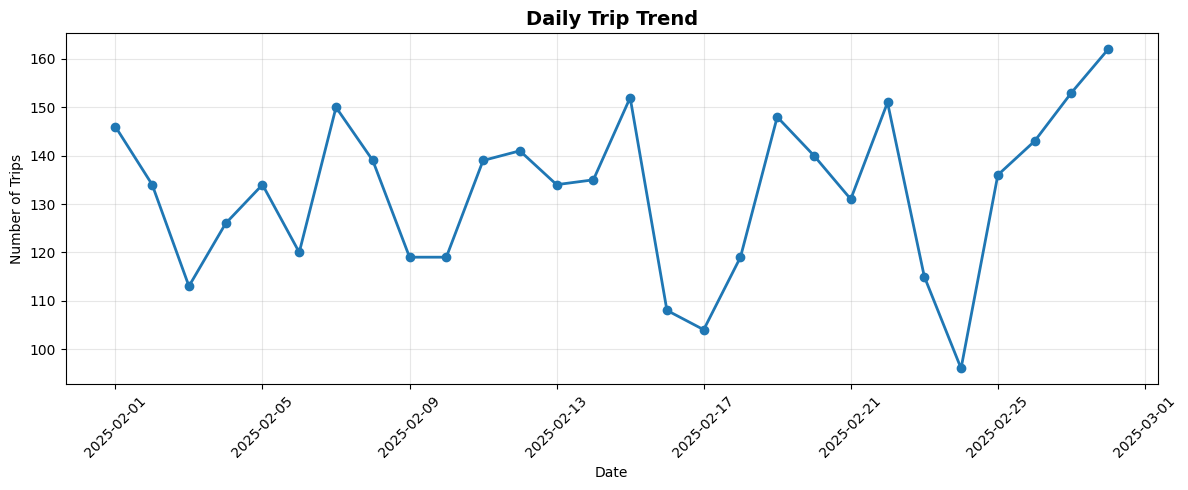

✅ Visualized 28 days


In [39]:
import matplotlib.pyplot as plt

# Data from Curated Zone
df_viz = pd.read_sql("SELECT * FROM curated.daily_trip_stats ORDER BY trip_date", curated_engine)

# Chart
plt.figure(figsize=(12, 5))
plt.plot(df_viz['trip_date'], df_viz['total_trips'], marker='o', linewidth=2)
plt.title('Daily Trip Trend', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"✅ Visualized {len(df_viz)} days")

### Chart 2: Daily Revenue

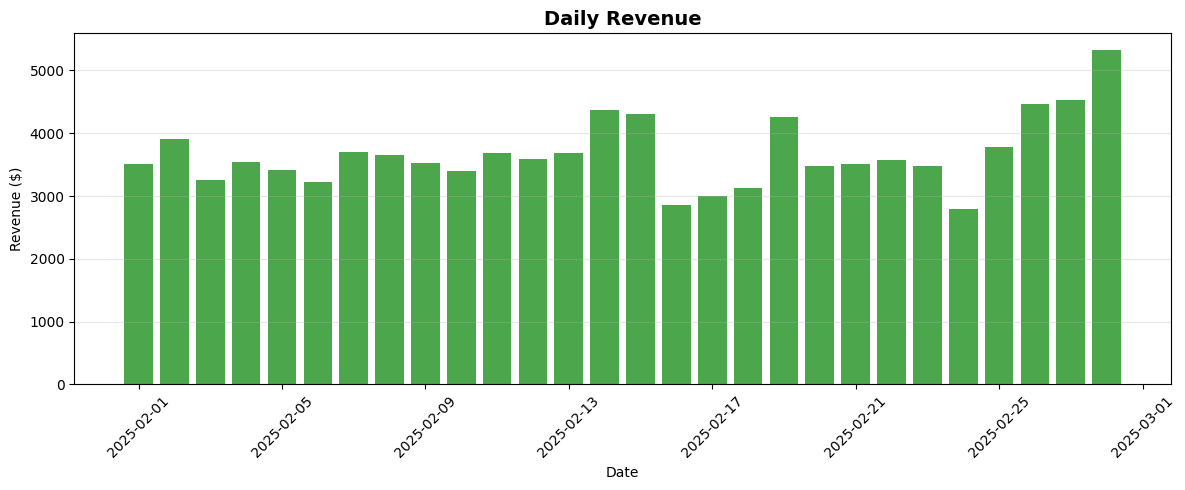

✅ Total revenue: $102,901.55


In [40]:
plt.figure(figsize=(12, 5))
plt.bar(df_viz['trip_date'], df_viz['total_revenue'], color='green', alpha=0.7)
plt.title('Daily Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_revenue = df_viz['total_revenue'].sum()
print(f"✅ Total revenue: ${total_revenue:,.2f}")

### Chart 3: Hourly Trip Distribution

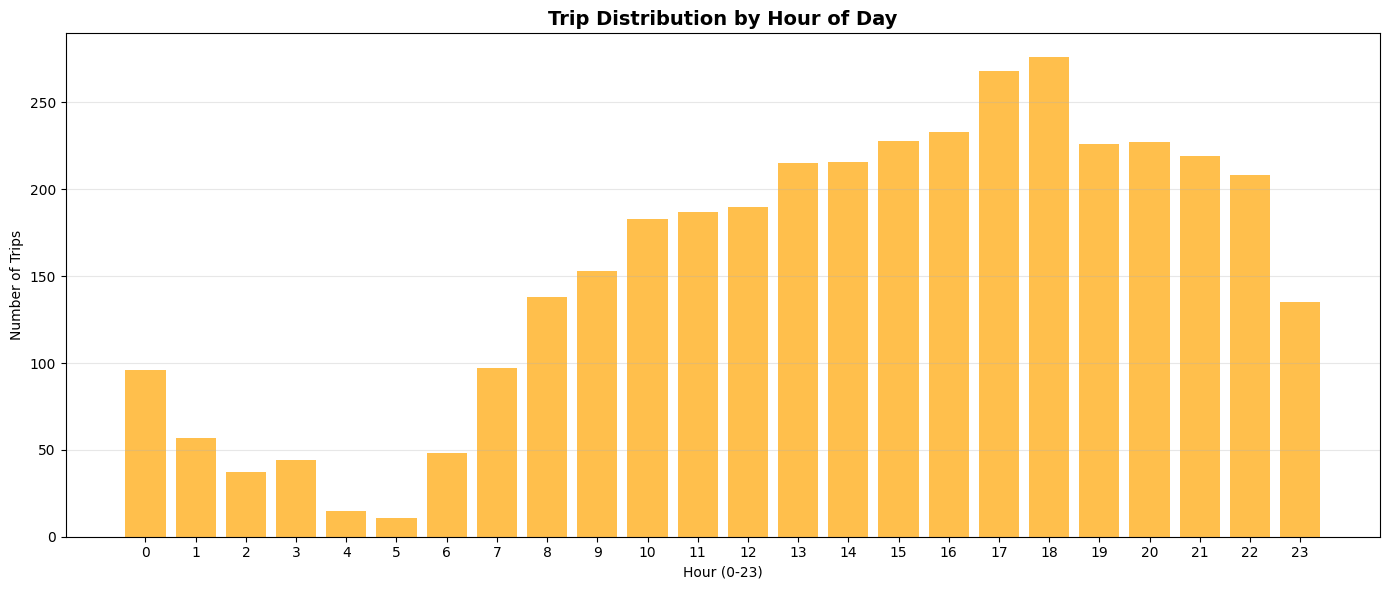

✅ Peak hour: 18:00 (276 trips)


In [41]:
# Query from Staging Zone
hourly_dist_query = """
SELECT hour_of_day, COUNT(*) as num_trips
FROM staging.clean_taxi_trips
GROUP BY hour_of_day
ORDER BY hour_of_day
"""
df_hourly_viz = pd.read_sql(hourly_dist_query, staging_engine)

# Chart
plt.figure(figsize=(14, 6))
plt.bar(df_hourly_viz['hour_of_day'], df_hourly_viz['num_trips'], color='orange', alpha=0.7)
plt.title('Trip Distribution by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour (0-23)')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

peak_hour = df_hourly_viz.loc[df_hourly_viz['num_trips'].idxmax()]
print(f"✅ Peak hour: {peak_hour['hour_of_day']}:00 ({peak_hour['num_trips']:,} trips)")